# Cohort Case Study 1 - Rebalancing

This notebook is a continuation of the notebook [Case 1](./case_1.ipynb). Here, we'll show a situation where using the ``CohortManager`` to rebalance the dataset is a good idea.

First of all, we'll need to create the artificial dataset once again. We'll just copy the code used in the previous notebook.

In [11]:
import random
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from raimitigations.utils import split_data
import raimitigations.dataprocessing as dp
from raimitigations.cohort import (
    CohortDefinition,
    CohortManager,
    fetch_cohort_results,
    plot_value_counts_cohort
)

SEED = 51
#SEED = None
np.random.seed(SEED)
random.seed(SEED)

def _create_country_df(samples: int, sectors: dict, country_name: str):
    df = None
    for key in sectors.keys():
        size = int(samples * sectors[key]["prob_occur"])
        invest = np.random.uniform(low=sectors[key]["min"], high=sectors[key]["max"], size=size)
        min_invest = min(invest)
        max_invest = max(invest)
        range_invest = max_invest - min_invest
        bankrupt_th = sectors[key]["prob_success"] * range_invest
        inverted_behavior = sectors[key]["inverted_behavior"]
        bankrupt = []
        for i in range(invest.shape[0]):
            inst_class = 1
            if invest[i] > bankrupt_th:
                inst_class = 0
            if inverted_behavior:
                inst_class = int(not inst_class)
            bankrupt.append(inst_class)
        noise_ind = np.random.choice(range(size), int(size*0.05), replace=False)
        for ind in noise_ind:
            bankrupt[ind] = int(not bankrupt[ind])
        noise_ind = np.random.choice(range(size), int(size*0.1), replace=False)
        for ind in noise_ind:
            invest[ind] = np.nan
        
        country_col = [country_name for _ in range(size)]
        sector_col = [key for _ in range(size)]
        df_sector = pd.DataFrame({
            "investment":invest,
            "sector":sector_col,
            "country":country_col,
            "bankrupt":bankrupt
        })
        
        if df is None:
            df = df_sector
        else:
            df = pd.concat([df, df_sector], axis=0)
    return df

def create_df_multiple_distributions(samples: list):
    sectors_c1 = {
        "s1": {"prob_occur":0.5, "prob_success":0.99, "inverted_behavior":False, "min":2e6, "max":1e7},
        "s2": {"prob_occur":0.1, "prob_success":0.2, "inverted_behavior":False, "min":1e7, "max":1.5e9},
        "s3": {"prob_occur":0.1, "prob_success":0.9, "inverted_behavior":True, "min":1e9, "max":1e10},
        "s4": {"prob_occur":0.3, "prob_success":0.7, "inverted_behavior":False, "min":4e10, "max":9e13},
    }
    sectors_c2 = {
        "s1": {"prob_occur":0.1, "prob_success":0.6, "inverted_behavior":True, "min":1e3, "max":5e3},
        "s2": {"prob_occur":0.3, "prob_success":0.9, "inverted_behavior":False, "min":1e5, "max":1.5e6},
        "s3": {"prob_occur":0.5, "prob_success":0.3, "inverted_behavior":False, "min":5e4, "max":3e5},
        "s4": {"prob_occur":0.1, "prob_success":0.8, "inverted_behavior":False, "min":1e6, "max":1e7},
    }
    sectors_c3 = {
        "s1": {"prob_occur":0.3, "prob_success":0.9, "inverted_behavior":False, "min":3e2, "max":6e2},
        "s2": {"prob_occur":0.6, "prob_success":0.7, "inverted_behavior":False, "min":5e3, "max":9e3},
        "s3": {"prob_occur":0.07, "prob_success":0.6, "inverted_behavior":False, "min":4e3, "max":2e4},
        "s4": {"prob_occur":0.03, "prob_success":0.1, "inverted_behavior":True, "min":6e5, "max":1.3e6},
    }
    countries = {
        "A":{"sectors":sectors_c1, "sample_rate":0.85},
        "B":{"sectors":sectors_c2, "sample_rate":0.05},
        "C":{"sectors":sectors_c2, "sample_rate":0.1}
    }
    df = None
    for key in countries.keys():
        n_sample = int(samples * countries[key]["sample_rate"])
        df_c = _create_country_df(n_sample, countries[key]["sectors"], key)
        if df is None:
            df = df_c
        else:
            df = pd.concat([df, df_c], axis=0)
    
    idx = pd.Index([i for i in range(df.shape[0])])
    df = df.set_index(idx)
    return df


Let's now create our artificial dataset:

In [12]:
df = create_df_multiple_distributions(10000)
df

,investment,sector,country,bankrupt
0,7.405851e+06,s1,A,1
1,2.357697e+06,s1,A,1
2,4.746429e+06,s1,A,1
3,7.152158e+06,s1,A,1
4,NaN,s1,A,1
...,...,...,...,...
9995,4.226512e+06,s4,C,1
9996,3.566758e+06,s4,C,0
9997,9.281006e+06,s4,C,0
9998,5.770378e+06,s4,C,1


We'll now split our dataset into train and test sets:

In [13]:
X_train, X_test, y_train, y_test = split_data(df, label="bankrupt", test_size=0.3)

In [14]:
def get_model():
    #model = LGBMClassifier(random_state=SEED)
    model = LogisticRegression(random_state=SEED)
    return model

## Rebalancing

In the following experiments, we'll test different ways the ``Rebalance`` class can be used in this dataset.

Using the `plot_value_counts_cohort` function with the subsets returned by the ``CohortManager`` class, let's take a look at the label distributions of the cohorts based on the ``sector`` and ``country`` columns:

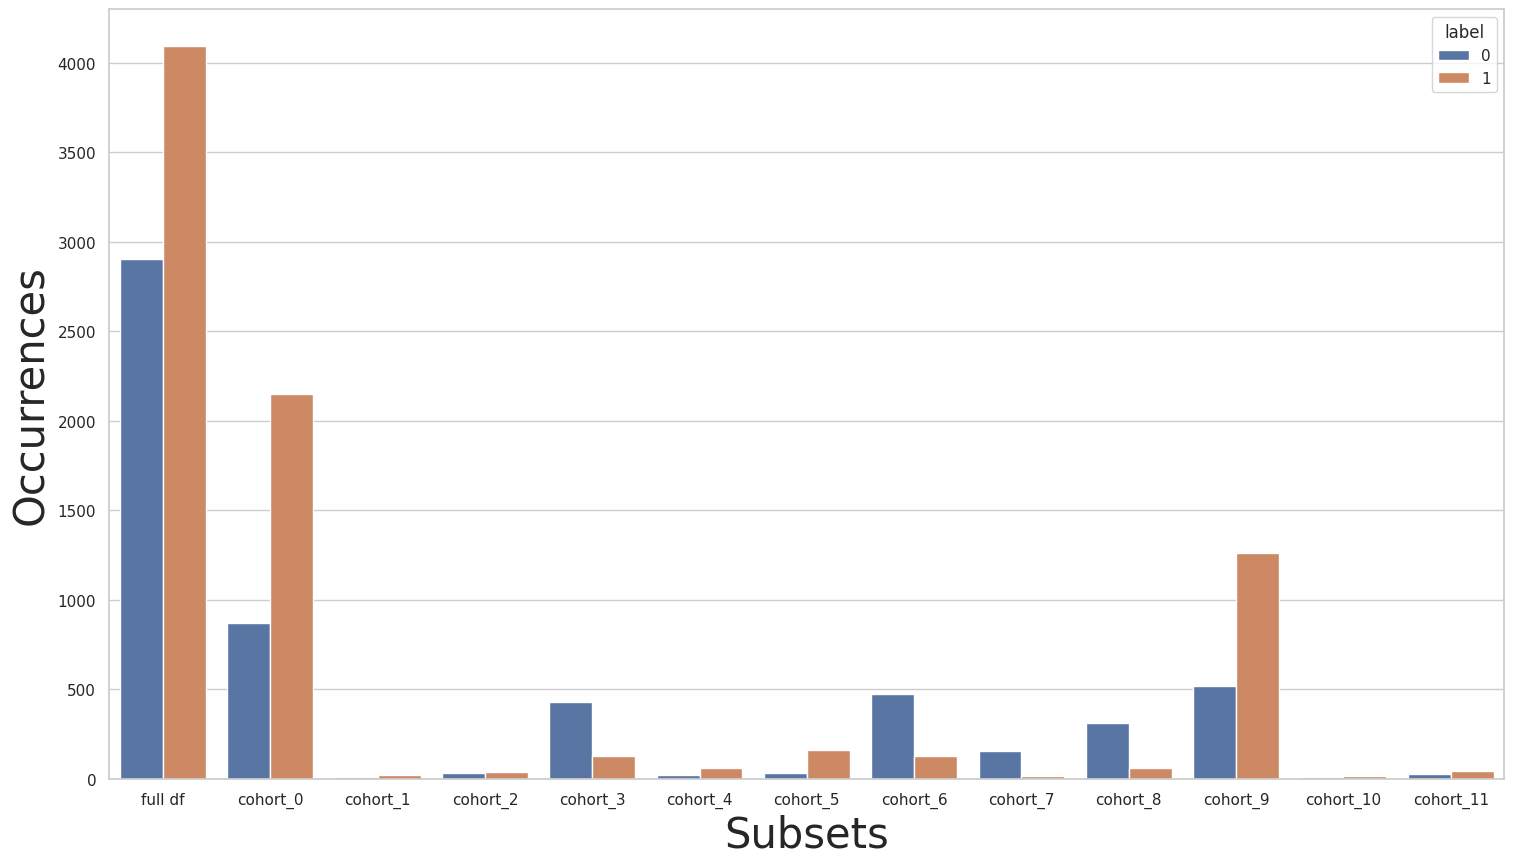

In [16]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

plot_value_counts_cohort(y_train, subsets, normalize=False)

As we can see, there is a slight class imbalance in the entire dataset, but if we look at each cohort individually, this imbalance varies greatly. We can see that the imbalance is inverted for some cohorts.

### Rebalance the entire dataset

For our first experiment, let's try rebalancing the entire dataset to see how this will affect the results. Note that we don't expect great changes to the results, since the imbalance in the entire dataset is not very accentuated.

We'll use the ``Rebalance`` class to rebalance the full dataset. We then plot the label distributions for all cohorts once again to see how the rebalance process affected the distributions inside each cohort.

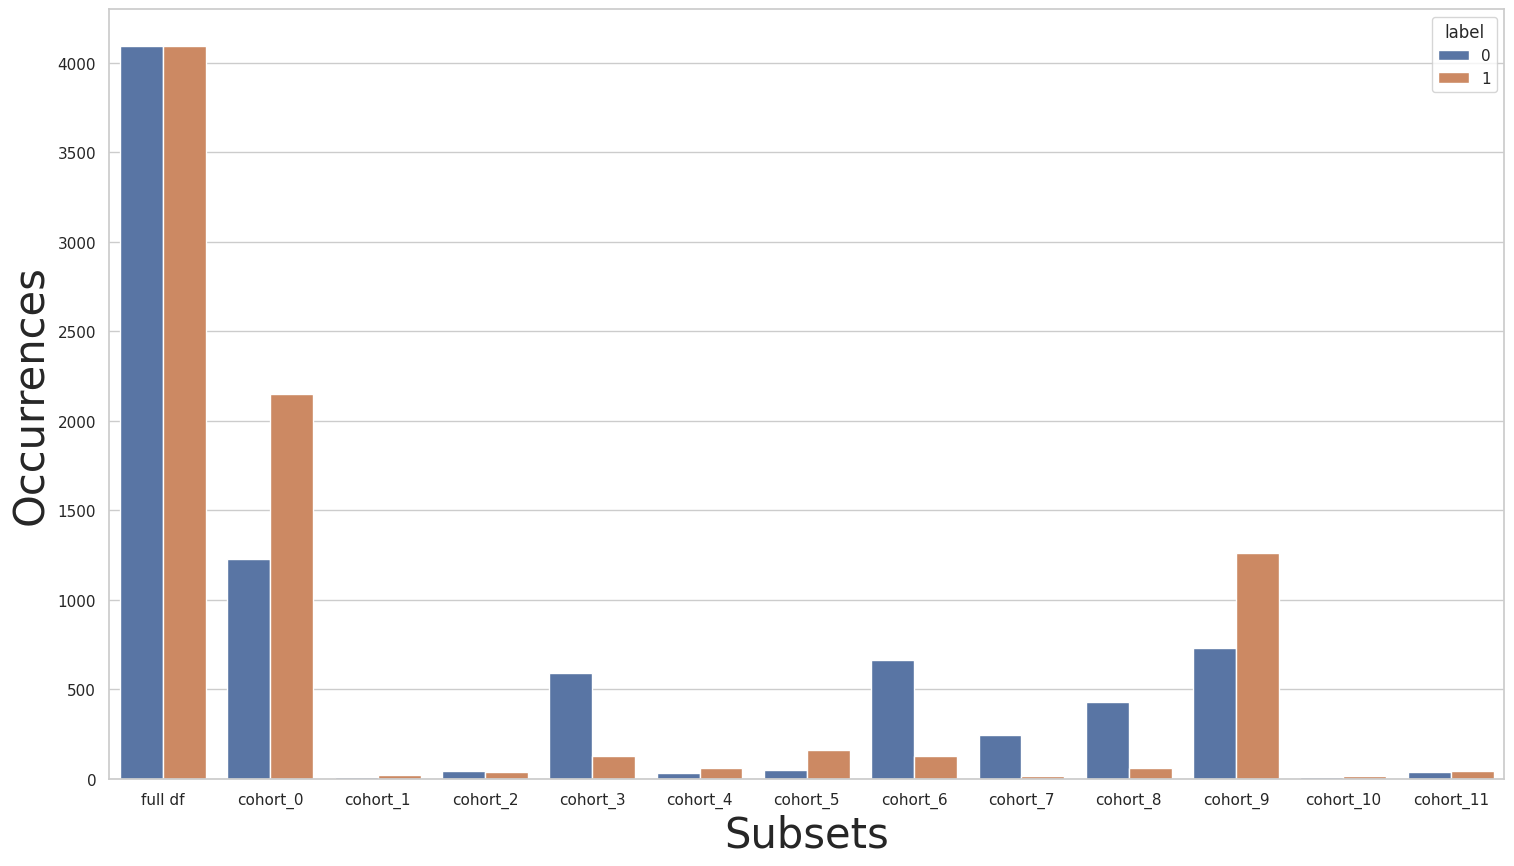

In [17]:
rebalance = dp.Rebalance(verbose=False)
new_X_train, new_y_train = rebalance.fit_resample(X_train, y_train)

cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(new_X_train,new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

As we can see, after rebalancing the full dataset, there is no class imbalance when we look at the full dataset. However, the imbalance inside the cohorts with an inverted class imbalanced (compared to the full dataset) has only been more accentuated.

Let's now check how this new rebalanced dataset impacts the training process when using the baseline pipeline ([Case 1 - Baseline 3](./case_1.ipynb)), where we train a single pipeline for the entire dataset.

<a id='rebalance_base1'></a>

In [18]:
#EXPERIMENT: Rebalance-Base 1

pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

pred_train_org = pipe.predict_proba(new_X_train)
_, th_dict = fetch_cohort_results(new_X_train, new_y_train, pred_train_org, cohort_col=["sector", "country"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"], fixed_th=th_dict)

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:1

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,cht_size
0,all,all,0.803268,0.788877,0.790533,0.769316,0.769333,0.639927,3000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",0.852323,0.860370,0.896209,0.873737,0.888436,0.639927,1228
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",0.238095,0.208333,0.416667,0.277778,0.384615,0.649560,13
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",0.161905,0.232143,0.464286,0.309524,0.448276,0.715199,29
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",0.803265,0.930028,0.852337,0.882836,0.920962,0.332854,291
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",0.813390,0.803529,0.867521,0.828205,0.880597,0.342261,67
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",0.775021,0.701744,0.787014,0.730828,0.858491,0.413488,106
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",0.188799,0.575122,0.529032,0.285017,0.304878,0.125266,246
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",0.710065,0.913043,0.684211,0.721612,0.842105,0.129994,76
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",0.766817,0.848348,0.785480,0.811509,0.899225,0.168353,129


From the previous results, we can see that the results haven't changed much (compared to [Case 1 - Baseline 3](./case_1.ipynb)). This is true for the full dataset, as well as when we analyze each cohort individually. Therefore, this rebalancing process didn't impact the results for the baseline pipeline.

In the following cell, we use the rebalanced dataset in the cohort-based pipeline ([Case 1 - Cohort 5](./case_1.ipynb)).

<a id='rebalance_cohort1'></a>

In [19]:
#EXPERIMENT: Rebalance-Cohort 1

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

pred_train = cht_manager.predict_proba(new_X_train)
_, th_dict = fetch_cohort_results(new_X_train, new_y_train, pred_train, cohort_col=["sector", "country"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"], fixed_th=th_dict)

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predic

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,cht_size
0,all,all,0.827125,0.814789,0.820160,0.801492,0.801667,0.637556,3000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",0.852323,0.860370,0.896209,0.873737,0.888436,0.637556,1228
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",0.761905,0.888889,0.833333,0.837500,0.846154,0.635485,13
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",0.838095,0.899038,0.895238,0.896057,0.896552,0.466120,29
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",0.196735,0.378007,0.500000,0.430528,0.756014,0.193607,291
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",0.186610,0.097015,0.500000,0.162500,0.194030,0.781296,67
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",0.224979,0.061321,0.500000,0.109244,0.122642,0.832238,106
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",0.188799,0.575122,0.529032,0.285017,0.304878,0.170009,246
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",0.710065,0.913043,0.684211,0.721612,0.842105,0.061715,76
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",0.766817,0.848348,0.785480,0.811509,0.899225,0.122870,129


We can see that by comparing the previous results with the one obtained by using the cohort-based pipeline (the one for the cohorts based on the ``sector`` and ``country`` columns - [Case 1 - Cohort 5](./case_1.ipynb)) over the original dataset, we can notice that the new rebalanced dataset performed considerably worse. Using the original dataset, we managed to get good metrics for the entire dataset and for each individual cohort. But when we use the rebalanced dataset, the metrics for some cohorts have become severely worse (for example, the metrics for cohort ``cohort_4``). One possible explanation for this is that, given that each cohort behaves very differently from the other, the new instances created by the SMOTE method (used internally by the ``Rebalance`` class) for some cohorts are not very befitting to the behavior analyzed in each cohort. This is especially true in smaller cohorts, that have fewer data points that can be used in the data creation process used in SMOTE. However, this has little impact when we train a pipeline over the full dataset since these small cohorts are already marginalized in these pipelines. But when we train a separate pipeline for each cohort, and we insert noisy data points into small cohorts, this noise has a great impact on the resulting estimator, as we can see from the previous results.

We can check this by printing the statistics for the investment column for all cohorts in the original dataset and for the rebalanced dataset. Notice how the value range changes drastically from the original to the rebalanced datasets for several cohorts. The mean and standard deviation also suffers great changes.

In [20]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets_original = cohort_set.get_subsets(X_train, y_train, apply_transform=False)
subsets_rebalance = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

for cht_name in subsets_original.keys():
    min_value = subsets_original[cht_name]["X"]["investment"].min()
    max_value = subsets_original[cht_name]["X"]["investment"].max()
    mean = subsets_original[cht_name]["X"]["investment"].mean()
    std = subsets_original[cht_name]["X"]["investment"].std()
    print(f"{cht_name}:")
    print(f"\tORIGINAL: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")
    min_value = subsets_rebalance[cht_name]["X"]["investment"].min()
    max_value = subsets_rebalance[cht_name]["X"]["investment"].max()
    mean = subsets_rebalance[cht_name]["X"]["investment"].mean()
    std = subsets_rebalance[cht_name]["X"]["investment"].std()
    print(f"\tREBALANCE: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")

cohort_0:
	ORIGINAL: (min, max, mean, std) = (2.005068e+06, 9.998027e+06, 5.976259e+06, 2.339736e+06)
	REBALANCE: (min, max, mean, std) = (2.005068e+06, 1.098854e+13, 1.040341e+12, 3.217533e+12)
cohort_1:
	ORIGINAL: (min, max, mean, std) = (1.182911e+03, 4.987448e+03, 3.215314e+03, 1.206982e+03)
	REBALANCE: (min, max, mean, std) = (1.182911e+03, 1.098854e+13, 1.127030e+12, 3.377380e+12)
cohort_2:
	ORIGINAL: (min, max, mean, std) = (1.149726e+03, 4.982145e+03, 2.959479e+03, 1.251280e+03)
	REBALANCE: (min, max, mean, std) = (1.149726e+03, 1.098854e+13, 1.046528e+12, 3.244988e+12)
cohort_3:
	ORIGINAL: (min, max, mean, std) = (1.516971e+07, 1.499138e+09, 7.909766e+08, 4.417939e+08)
	REBALANCE: (min, max, mean, std) = (1.516971e+07, 1.098854e+13, 1.252196e+12, 3.492966e+12)
cohort_4:
	ORIGINAL: (min, max, mean, std) = (1.068535e+05, 1.493043e+06, 8.164178e+05, 4.428167e+05)
	REBALANCE: (min, max, mean, std) = (1.068535e+05, 1.098854e+13, 9.555261e+11, 3.113221e+12)
cohort_5:
	ORIGINAL: (min

### Rebalance only a specific cohort

Suppose now that we are interested in improving the performance over a single cohort, not the entire dataset. For example, let's consider that we are satisfied with the results obtained for all cohorts except for cohort ``cohort_7`` in the experiment [Case 1 - Cohort 5](./case_1.ipynb). This way, we want to improve the metrics only for this cohort and try to leave the other cohorts as is. To this end, we'll use the ``Rebalance`` class once again, but this time we'll use it inside the ``CohortManager`` class. This way, we'll be able to rebalance only a specific set of cohorts. We'll use an empty list of transformations for all cohorts except for ``cohort_7``, which is the 8th cohort in the list.

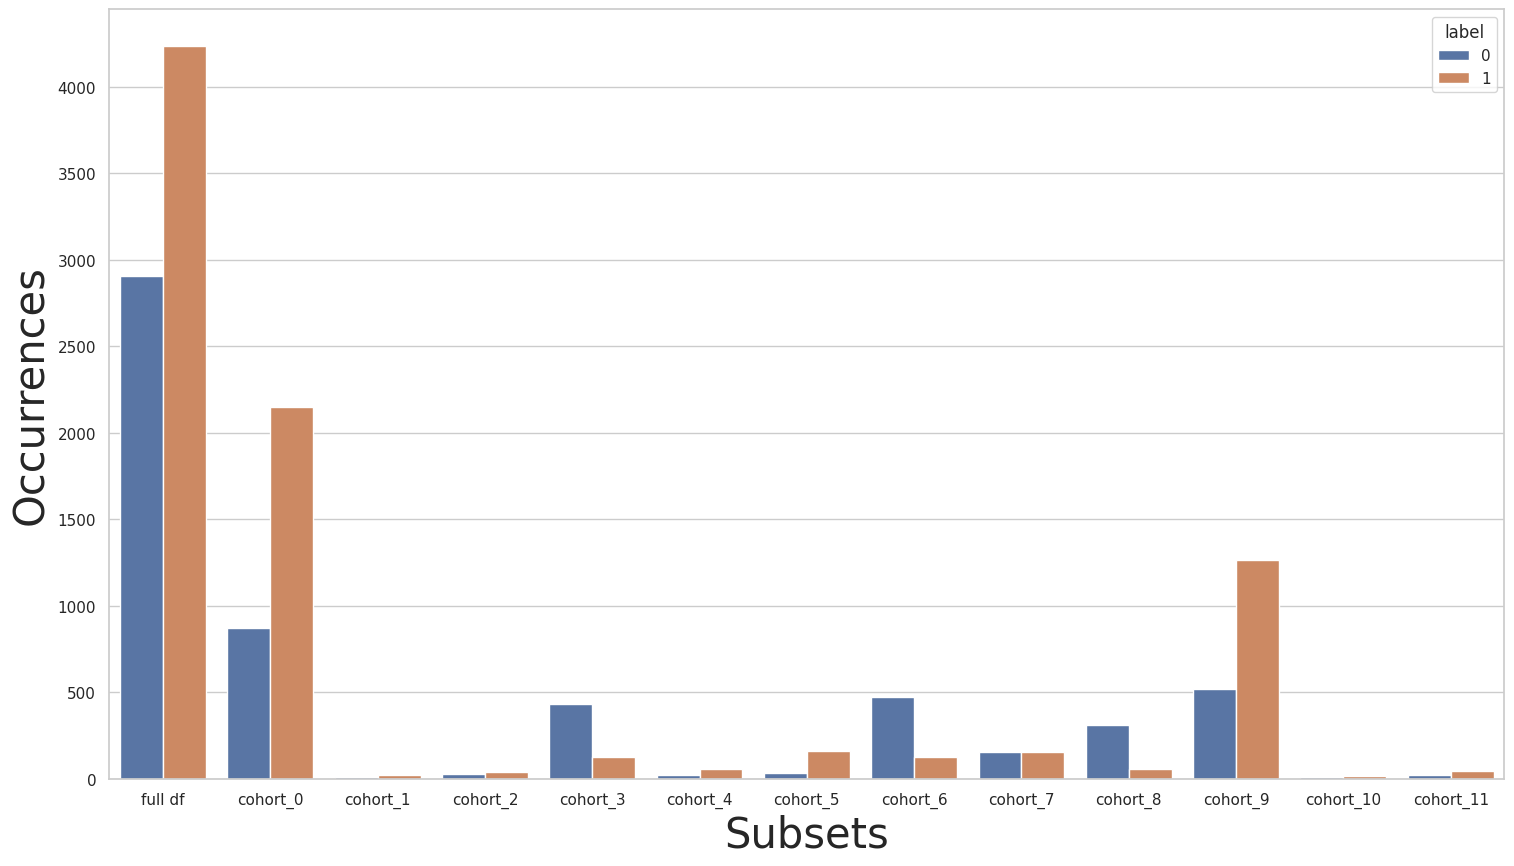

In [21]:

rebalance_cohort = CohortManager(
    transform_pipe=[[], [], [], [], [], [], [], [dp.Rebalance(verbose=False)], [], [], [], []],
    cohort_col=["sector", "country"]
)
new_X_train, new_y_train = rebalance_cohort.fit_resample(X_train, y_train)

subsets = rebalance_cohort.get_subsets(new_X_train,new_y_train, apply_transform=False)

plot_value_counts_cohort(new_y_train, subsets, normalize=False)

Let's check if the new instances created are very different from the original instances from cohort ``cohort_7``:

In [22]:
cohort_set = CohortManager(
    cohort_col=["sector", "country"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets_original = cohort_set.get_subsets(X_train, y_train, apply_transform=False)
subsets_rebalance = cohort_set.get_subsets(new_X_train, new_y_train, apply_transform=False)

cht_name = "cohort_7"
min_value = subsets_original[cht_name]["X"]["investment"].min()
max_value = subsets_original[cht_name]["X"]["investment"].max()
mean = subsets_original[cht_name]["X"]["investment"].mean()
std = subsets_original[cht_name]["X"]["investment"].std()
print(f"{cht_name}:")
print(f"\tORIGINAL: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")
min_value = subsets_rebalance[cht_name]["X"]["investment"].min()
max_value = subsets_rebalance[cht_name]["X"]["investment"].max()
mean = subsets_rebalance[cht_name]["X"]["investment"].mean()
std = subsets_rebalance[cht_name]["X"]["investment"].std()
print(f"\tREBALANCE: (min, max, mean, std) = ({min_value:e}, {max_value:e}, {mean:e}, {std:e})")

cohort_7:
	ORIGINAL: (min, max, mean, std) = (5.059673e+04, 2.994070e+05, 1.814661e+05, 7.001416e+04)
	REBALANCE: (min, max, mean, std) = (5.059673e+04, 2.994070e+05, 1.383858e+05, 7.739440e+04)


As we can see, the values for the ``investment`` column suffered only slight changes to the mean and standard deviation. This shows that in some cases, rebalancing certain cohorts separately is less harmful than rebalancing the entire dataset.

With our new rebalanced dataset, let's repeat the previous experiments:

1. train the baseline pipeline over the rebalanced dataset ([Rebalance-Base 1](#rebalance_base1));
2. train the cohort-based pipeline over the rebalanced dataset ([Rebalance-Cohort 1](#rebalance_cohort1));

In the following cell, we perform the first of these two experiments:

<a id='rebalance_base2'></a>

In [23]:
#EXPERIMENT: Rebalance-Base 2

pipe = Pipeline([
            ("imputer", dp.BasicImputer(verbose=False)),
            ("scaler", dp.DataMinMaxScaler(verbose=False)),
            ("encoder", dp.EncoderOHE(verbose=False)),
            ("estimator", get_model()),
        ])
pipe.fit(new_X_train, new_y_train)
pred_org = pipe.predict_proba(X_test)

pred_train_org = pipe.predict_proba(new_X_train)
_, th_dict = fetch_cohort_results(new_X_train, new_y_train, pred_train_org, cohort_col=["sector", "country"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_org, cohort_col=["sector", "country"], fixed_th=th_dict)

/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:189: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/home/mmendonca/ResponsibleAI/code/git/responsible-ai-mitigations/raimitigations/utils/metric_utils.py:1

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,cht_size
0,all,all,0.804837,0.788418,0.790132,0.768981,0.769000,0.712906,3000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",0.852323,0.860370,0.896209,0.873737,0.888436,0.712906,1228
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",0.238095,0.208333,0.416667,0.277778,0.384615,0.893269,13
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",0.161905,0.232143,0.464286,0.309524,0.448276,0.782414,29
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",0.803265,0.867622,0.834155,0.848937,0.893471,0.377946,291
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",0.813390,0.803529,0.867521,0.828205,0.880597,0.671898,67
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",0.775021,0.701744,0.787014,0.730828,0.858491,0.468042,106
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",0.188799,0.575122,0.529032,0.285017,0.304878,0.196127,246
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",0.710065,0.913043,0.684211,0.721612,0.842105,0.451353,76
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",0.766817,0.889474,0.773175,0.814833,0.906977,0.261151,129


As we can see, the results obtained are very similar to the baseline pipeline over the original dataset ([Case 1 - Baseline 3](./case_1.ipynb)). This was already expected, since ``cohort_7`` is a small cohort, and since we are training a single pipeline over the entire dataset, the new instances added had little impact on the results of the other cohorts.

Let's now check how this rebalancing process impacts the cohort-based pipeline:

<a id='rebalance_cohort2'></a>

In [24]:
#EXPERIMENT: Rebalance-Cohort 2

cht_manager = CohortManager(
    transform_pipe=[
        dp.BasicImputer(verbose=False),
        dp.DataMinMaxScaler(verbose=False),
        dp.EncoderOHE(verbose=False),
        get_model()
    ],
    cohort_col=["sector", "country"]
)
cht_manager.fit(new_X_train, new_y_train)
pred_cht = cht_manager.predict_proba(X_test)

pred_train = cht_manager.predict_proba(new_X_train)
_, th_dict = fetch_cohort_results(new_X_train, new_y_train, pred_train, cohort_col=["sector", "country"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["sector", "country"], fixed_th=th_dict)

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,cht_size
0,all,all,0.923553,0.908323,0.898396,0.902471,0.906333,0.475074,3000
1,cohort_0,"(`sector` == ""s1"") and (`country` == ""A"")",0.911655,0.941368,0.894939,0.914116,0.931596,0.445645,1228
2,cohort_1,"(`sector` == ""s1"") and (`country` == ""B"")",0.904762,0.888889,0.833333,0.837500,0.846154,0.616965,13
3,cohort_2,"(`sector` == ""s1"") and (`country` == ""C"")",0.914286,0.899038,0.895238,0.896057,0.896552,0.471948,29
4,cohort_3,"(`sector` == ""s2"") and (`country` == ""A"")",0.861716,0.867622,0.834155,0.848937,0.893471,0.488684,291
5,cohort_4,"(`sector` == ""s2"") and (`country` == ""B"")",0.814815,0.914912,0.836895,0.868782,0.925373,0.521201,67
6,cohort_5,"(`sector` == ""s2"") and (`country` == ""C"")",0.874276,0.929167,0.840778,0.878077,0.952830,0.662477,106
7,cohort_6,"(`sector` == ""s3"") and (`country` == ""A"")",0.875000,0.943813,0.877957,0.905093,0.934959,0.477076,246
8,cohort_7,"(`sector` == ""s3"") and (`country` == ""B"")",0.787627,0.913043,0.684211,0.721612,0.842105,0.771149,76
9,cohort_8,"(`sector` == ""s3"") and (`country` == ""C"")",0.780353,0.889474,0.773175,0.814833,0.906977,0.388728,129


Notice that we managed to get a slight improvement over the ROC AUC metric for ``cohort_7`` (compared to [Case 1 - Cohort 5](./case_1.ipynb)), although the other metrics were left unchanged. It is interesting to note that the threshold used for ``cohort_7`` changed considerably when compared to the cohort-based pipeline trained over the original dataset ([Case 1 - Cohort 5](./case_1.ipynb)).